In [217]:
!pip install torch torchvision transformers opencv-python scikit-learn googletrans==4.0.0rc1

In [218]:
import pandas as pd

# Load the CSV file
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTyh006zrmSWoKAwqF92kZ4lvNRKsZL5NYIkdSEK3wtrWA8yMKLT6K3h1k1nyyHjG9ntZvc9tTcbUif/pub?output=csv'
df = pd.read_csv(url,encoding="utf-8")
df.head()


,id,caption,label,level,area,Unnamed: 5
0,1,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
1,2,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
2,3,কুমিল্লা,flood,1.0,কুমিল্লা,NaN
3,4,আখাউড়া উপজেলা ও কসবা উপজেলা'র বিভিন্ন এলাকায় ই...,flood,1.0,আখাউড়া,NaN
4,5,ফেনীর মুহুরী নদীতে পানির মাত্রা গত ৪০ বছরের ইত...,flood,1.0,ফেনী,NaN


In [219]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import shuffle, class_weight
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import random


In [220]:
# Drop unnecessary columns if they exist
columns_to_drop = [col for col in ['level', 'area', 'Unnamed: 5'] if col in df.columns]
df = df.drop(columns_to_drop, axis=1)

# Shuffle the dataframe
df = shuffle(df, random_state=42)

In [221]:
# Verify column names
print(df.columns)

Index([' id', 'caption', 'label'], dtype='object')


In [222]:
print(df['label'].unique())


['Anthropogenic' 'Non Informative' 'Fire' 'flood' 'Cyclone'
 'River Erosion' 'Earthquake']


In [223]:
import pandas as pd

# Define the mapping
label_mapping = {
    'flood': 0,
    'Cyclone': 1,
    'Earthquake': 2,
    'River Erosion': 3,
    'Fire' : 4,
    'Anthropogenic': 5
}

# Remove 'Non Informative' rows
df = df[df['label'] != 'Non Informative']

# Assign new integer labels
df['label'] = df['label'].map(label_mapping)

# Display updated labels
print(df['label'].unique())


[5 4 0 1 3 2]


In [224]:
print(df['label'].value_counts())

label
5    697
0    510
1    509
4    505
2    500
3    445
Name: count, dtype: int64


In [225]:
# Split the dataset
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_data, val_test = train_test_split(df, train_size=train_ratio, random_state=42)
valid_data, test_data = train_test_split(val_test, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)

In [226]:
train_data.columns = train_data.columns.str.strip()
valid_data.columns = valid_data.columns.str.strip()
test_data.columns = test_data.columns.str.strip()

# # Prepare data for TextDataset
# X_train = train_data['caption'].values
# y_train = train_data['label'].values
# X_valid = valid_data['caption'].values
# y_valid = valid_data['label'].values
# X_test = test_data['caption'].values
# y_test = test_data['label'].values


In [227]:
# Data augmentation functions
def random_deletion_bn(text, p=0.1):
    words = text.split()
    if len(words) == 1:
        return text
    remaining = [w for w in words if random.uniform(0,1) > p]
    if not remaining:
        return random.choice(words)
    return ' '.join(remaining)

def random_swap_bn(text, n=1):
    words = text.split()
    length = len(words)
    if length < 2:
        return text
    for _ in range(n):
        idx1, idx2 = random.sample(range(length), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

def char_noise_bn(text, p=0.03):
    noisy_text = ''
    for c in text:
        if random.uniform(0,1) < p and c != ' ':
            noisy_text += random.choice('অআইঈউঊঋএঐওঔকখগঘচছজঝটঠডঢতথদধনপফবভমযরলশষসহ')
        else:
            noisy_text += c
    return noisy_text

def augment_bengali_text(text):
    aug_choice = random.choice(['delete', 'swap', 'char_noise', 'none'])
    if aug_choice == 'delete':
        return random_deletion_bn(text, p=0.1)
    elif aug_choice == 'swap':
        return random_swap_bn(text, n=1)
    elif aug_choice == 'char_noise':
        return char_noise_bn(text, p=0.03)
    else:
        return text

# Apply augmentation to training data
train_data, val_test = train_test_split(df, train_size=0.6, random_state=42)
valid_data, test_data = train_test_split(val_test, train_size=0.5, random_state=42)
train_data['caption_aug'] = train_data['caption'].apply(augment_bengali_text)

In [228]:
# Prepare data
X_train = train_data['caption_aug'].values
y_train = train_data['label'].values
X_valid = valid_data['caption'].values
y_valid = valid_data['label'].values
X_test = test_data['caption'].values
y_test = test_data['label'].values

In [229]:
# # Build vocabulary
# vocab = set(' '.join(X_train).split())
# word2idx = {word: idx + 1 for idx, word in enumerate(vocab)}  # 0 is reserved for padding
# word2idx['<PAD>'] = 0

# # Create embeddings matrix (random for demonstration; replace with fastText)
# embedding_dim = 300
# vocab_size = len(word2idx)
# embedding_matrix = np.random.rand(vocab_size, embedding_dim).astype(np.float32)
# # Uncomment to use fastText embeddings (upload cc.bn.300.bin to Kaggle)
# # fasttext_model = KeyedVectors.load_word2vec_format('/kaggle/input/cc.bn.300.bin', binary=True)
# # for word, idx in word2idx.items():
# #     if word in fasttext_model:
# #         embedding_matrix[idx] = fasttext_model[word]

# # Define tokenization function
# def tokenize(text, max_length=50):
#     tokens = text.split()[:max_length]
#     token_ids = [word2idx.get(token, 0) for token in tokens]
#     if len(token_ids) < max_length:
#         token_ids += [0] * (max_length - len(token_ids))
#     return token_ids

In [230]:
from transformers import BertModel
bert_model = BertModel.from_pretrained('sagorsarker/bangla-bert-base')
embedding_matrix = bert_model.get_input_embeddings().weight.detach().numpy()
embedding_dim = embedding_matrix.shape[1]  # 768
vocab_size = embedding_matrix.shape[0]  # 101,975

tokenizer = BertTokenizer.from_pretrained('sagorsarker/bangla-bert-base')

In [231]:
# Modified TextDataset to align with LSTM input
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text,
                                  max_length=self.max_length,
                                  padding='max_length',
                                  truncation=True,
                                  return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].squeeze(0),  # Shape: (max_length,)
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [232]:
# Create datasets and dataloaders (unchanged)
train_dataset = TextDataset(X_train, y_train, tokenizer)
valid_dataset = TextDataset(X_valid, y_valid, tokenizer)
test_dataset = TextDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [233]:
# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [234]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                 n_layers, dropout, embedding_matrix=None, freeze_embedding=False):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if embedding_matrix is not None:
            self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
            self.embedding.weight.requires_grad = not freeze_embedding
        
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, num_layers=n_layers,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # bidirectional concat

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)
        # hidden shape: (num_layers * 2, batch_size, hidden_dim)
        # concat last forward and backward hidden state
        hidden_cat = torch.cat((hidden[-2], hidden[-1]), dim=1)
        dropped = self.dropout(hidden_cat)
        return self.fc(dropped)

In [235]:
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=.3)  # maybe reduce to 0.5 or 0.3
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    return total_loss / len(data_loader), all_preds, all_labels

Evaluating: 100%|██████████| 20/20 [00:00<00:00, 44.42it/s]


Unfreezing embeddings for fine-tuning...


Evaluating: 100%|██████████| 20/20 [00:00<00:00, 46.66it/s]
<ipython-input-236-cf1c62350960>:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.lo

Early stopping triggered at epoch 18


Evaluating: 100%|██████████| 20/20 [00:00<00:00, 46.03it/s]



Test Loss: 0.4935
Test Metrics:
               precision    recall  f1-score   support

        flood       0.72      0.89      0.79       114
      Cyclone       0.80      0.83      0.81        93
   Earthquake       0.91      0.83      0.87        84
River Erosion       0.86      0.78      0.82       101
         Fire       0.94      0.91      0.93       112
Anthropogenic       0.92      0.85      0.88       130

     accuracy                           0.85       634
    macro avg       0.86      0.85      0.85       634
 weighted avg       0.86      0.85      0.85       634



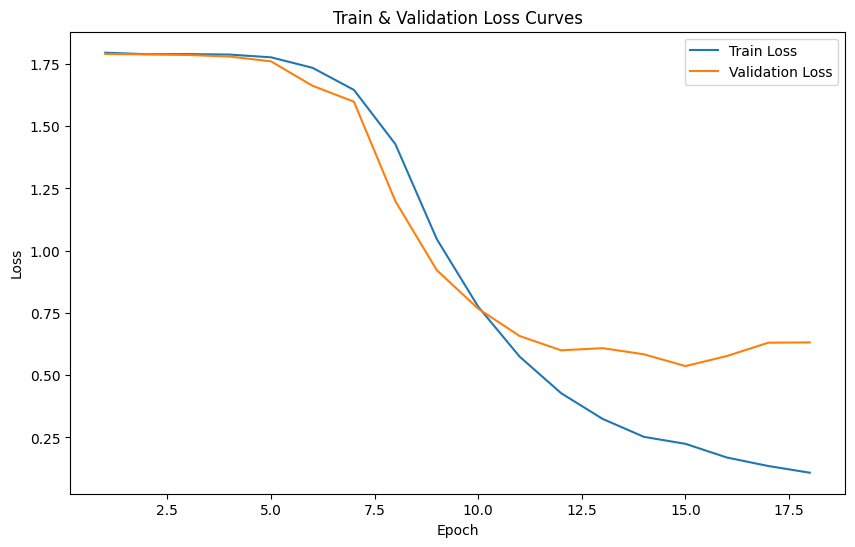

In [236]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
hidden_dim = 32
n_layers = 1
dropout = 0.5
output_dim = 6  # number of classes
epochs = 20
patience = 3

# Initialize model
model = LSTMClassifier(
    vocab_size, embedding_dim, hidden_dim, output_dim,
    n_layers, dropout, embedding_matrix,
    freeze_embedding=True  # freeze embeddings initially
).to(device)

# Move class_weights tensor to device
class_weights = class_weights.to(device)

# Optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True
)

best_val_loss = float('inf')
epochs_no_improve = 0
train_losses, val_losses = [], []

for epoch in range(epochs):
    if epoch == 7:
        print("Unfreezing embeddings for fine-tuning...")
        model.embedding.weight.requires_grad = True
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_preds, val_labels = evaluate(model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_lstm_model.pt')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Load best model and evaluate on test set
model.load_state_dict(torch.load('best_lstm_model.pt'))
test_loss, test_preds, test_labels = evaluate(model, test_loader, criterion, device)

print(f"\nTest Loss: {test_loss:.4f}")
print("Test Metrics:")
print(classification_report(test_labels, test_preds, target_names=label_mapping.keys()))

# Plot loss curves
plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train & Validation Loss Curves')
plt.legend()
plt.show()

<ipython-input-237-5d2225c44651>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_lstm_model.pt'))
Evaluating: 100%|██████████| 20/20 

Test Loss: 0.4935
Test Metrics:
               precision    recall  f1-score   support

        flood       0.72      0.89      0.79       114
      Cyclone       0.80      0.83      0.81        93
   Earthquake       0.91      0.83      0.87        84
River Erosion       0.86      0.78      0.82       101
         Fire       0.94      0.91      0.93       112
Anthropogenic       0.92      0.85      0.88       130

     accuracy                           0.85       634
    macro avg       0.86      0.85      0.85       634
 weighted avg       0.86      0.85      0.85       634



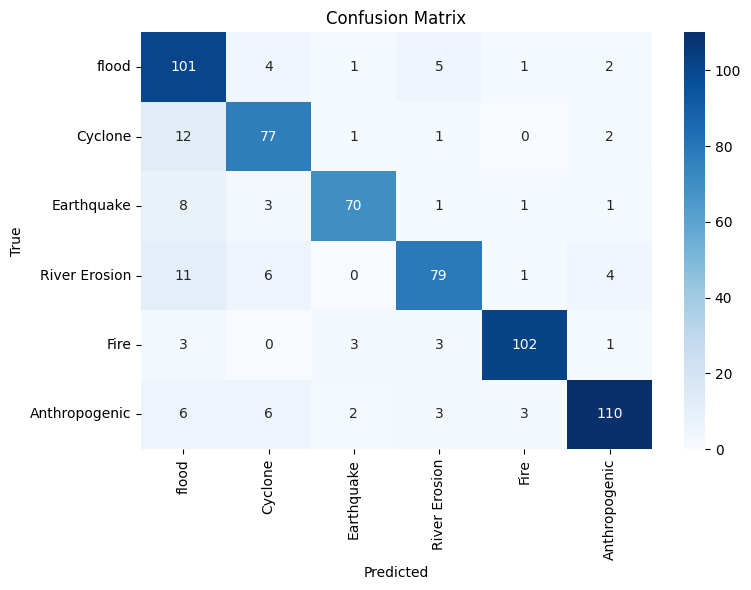

Epoch | Train Loss | Validation Loss
------------------------------
    1 | 1.7948    | 1.7899
    2 | 1.7889    | 1.7881
    3 | 1.7893    | 1.7856
    4 | 1.7873    | 1.7794
    5 | 1.7763    | 1.7602
    6 | 1.7342    | 1.6621
    7 | 1.6456    | 1.5981
    8 | 1.4279    | 1.1989
    9 | 1.0464    | 0.9216
   10 | 0.7747    | 0.7670
   11 | 0.5742    | 0.6571
   12 | 0.4277    | 0.5998
   13 | 0.3245    | 0.6085
   14 | 0.2522    | 0.5838
   15 | 0.2244    | 0.5365
   16 | 0.1694    | 0.5769
   17 | 0.1353    | 0.6304
   18 | 0.1083    | 0.6315


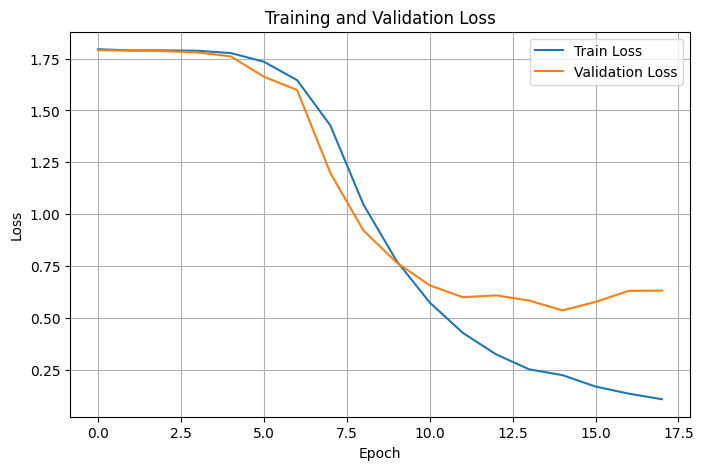

In [237]:
# Load best model and evaluate on test set
model.load_state_dict(torch.load('best_lstm_model.pt'))
test_loss, test_preds, test_labels = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Metrics:\n{classification_report(test_labels, test_preds, target_names=label_mapping.keys())}')

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig('confusion_matrix_lstm.png')
plt.show()

# Plot train and validation loss curves
print("Epoch | Train Loss | Validation Loss")
print("-" * 30)
for i, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses), 1):
    print(f"{i:5d} | {train_loss:.4f}    | {val_loss:.4f}")


plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()